<a href="https://colab.research.google.com/github/Songloading/Image-Classfication-Tasks/blob/main/jaxLenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import time
import itertools

import numpy.random as npr

import jax.numpy as np
from jax import jit, grad, random
from jax.experimental import optimizers
from jax.experimental import stax
from jax.experimental.stax import Dense, Relu, LogSoftmax, Conv, MaxPool, Flatten
# from examples import dataset

In [2]:
## This block is for data loading (MNIST)
import array
import gzip
import os
from os import path
import struct
import urllib.request

import numpy as np


_DATA = "/tmp/jax_example_data/"


def _download(url, filename):
  """Download a url to a file in the JAX data temp directory."""
  if not path.exists(_DATA):
    os.makedirs(_DATA)
  out_file = path.join(_DATA, filename)
  if not path.isfile(out_file):
    urllib.request.urlretrieve(url, out_file)
    print("downloaded {} to {}".format(url, _DATA))


def _partial_flatten(x):
  """Flatten all but the first dimension of an ndarray."""
  return np.reshape(x, (x.shape[0], -1))


def _one_hot(x, k, dtype=np.float32):
  """Create a one-hot encoding of x of size k."""
  return np.array(x[:, None] == np.arange(k), dtype)


def mnist_raw():
  """Download and parse the raw MNIST dataset."""
  # CVDF mirror of http://yann.lecun.com/exdb/mnist/
  base_url = "https://storage.googleapis.com/cvdf-datasets/mnist/"

  def parse_labels(filename):
    with gzip.open(filename, "rb") as fh:
      _ = struct.unpack(">II", fh.read(8))
      return np.array(array.array("B", fh.read()), dtype=np.uint8)

  def parse_images(filename):
    with gzip.open(filename, "rb") as fh:
      _, num_data, rows, cols = struct.unpack(">IIII", fh.read(16))
      return np.array(array.array("B", fh.read()),
                      dtype=np.uint8).reshape(num_data, rows, cols)

  for filename in ["train-images-idx3-ubyte.gz", "train-labels-idx1-ubyte.gz",
                   "t10k-images-idx3-ubyte.gz", "t10k-labels-idx1-ubyte.gz"]:
    _download(base_url + filename, filename)

  train_images = parse_images(path.join(_DATA, "train-images-idx3-ubyte.gz"))
  train_labels = parse_labels(path.join(_DATA, "train-labels-idx1-ubyte.gz"))
  test_images = parse_images(path.join(_DATA, "t10k-images-idx3-ubyte.gz"))
  test_labels = parse_labels(path.join(_DATA, "t10k-labels-idx1-ubyte.gz"))

  return train_images, train_labels, test_images, test_labels


def mnist(permute_train=False):
  """Download, parse and process MNIST data to unit scale and one-hot labels."""
  train_images, train_labels, test_images, test_labels = mnist_raw()

  train_images = _partial_flatten(train_images) / np.float32(255.)
  test_images = _partial_flatten(test_images) / np.float32(255.)
  train_labels = _one_hot(train_labels, 10)
  test_labels = _one_hot(test_labels, 10)

  if permute_train:
    perm = np.random.RandomState(0).permutation(train_images.shape[0])
    train_images = train_images[perm]
    train_labels = train_labels[perm]

  return train_images, train_labels, test_images, test_labels

In [3]:
# some useful materials:
# http://gcucurull.github.io/deep-learning/2020/04/20/jax-graph-neural-networks/
# https://jax.readthedocs.io/en/latest/_modules/jax/experimental/stax.html
# https://jax.readthedocs.io/en/latest/jax.experimental.stax.html

In [4]:
def loss(params, batch):
    inputs, targets = batch
    preds = predict(params, inputs)
    return -np.mean(np.sum(preds * targets, axis=1))

In [5]:
def accuracy(params, batch):
    inputs, targets = batch
    target_class = np.argmax(targets, axis=1)
    predicted_class = np.argmax(predict(params, inputs), axis=1)
    return np.mean(predicted_class == target_class)

In [6]:
# init_fun: initilization function for the parameters of the layer.
# apply_fun: forward computation function
## "The init_fun is used to initialize network parameters and the apply_fun takes parameters and inputs to produce outputs."
init_random_params, predict = stax.serial(
    Conv(out_chan=6, filter_shape=(5, 5), strides=(1, 1), padding="VALID"), Relu,
    MaxPool(window_shape=(2, 2), padding="VALID", spec="NCHW"),
    Conv(out_chan=16, filter_shape=(5, 5), strides=(1, 1), padding="VALID"), Relu,
    MaxPool(window_shape=(2, 2), padding="VALID", spec="NCHW"),
    Flatten,
    Dense(120), Relu,
    Dense(84), Relu,
    Dense(10), LogSoftmax)

In [8]:
rng = random.PRNGKey(0) ## explicitly generate state key

step_size = 0.001
num_epochs = 10
batch_size = 128
momentum_mass = 0.9


train_images, train_labels, test_images, test_labels = mnist()
print("Shape Before:" + str(train_images.shape))
num_train = train_images.shape[0]
num_complete_batches, leftover = divmod(num_train, batch_size) #divmod returns quotient and remainder of first param/ 2nd param
num_batches = num_complete_batches + bool(leftover)

train_images = np.asarray(train_images.reshape(-1, 1, 28, 28))
test_images = np.asarray(test_images.reshape(-1, 1, 28, 28))

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)
print(train_images.shape)

Shape Before:(60000, 784)
(60000, 1, 28, 28) (60000, 10)
(10000, 1, 28, 28) (10000, 10)
(60000, 1, 28, 28)


In [9]:
 def data_stream():
        rng = npr.RandomState(0)
        while True:
            perm = rng.permutation(num_train)
            for i in range(num_batches):
                batch_idx = perm[i * batch_size:(i + 1) * batch_size]
                yield train_images[batch_idx], train_labels[batch_idx]


In [13]:
batches = data_stream()
opt_init, opt_update, get_params = optimizers.sgd(step_size)
# Every optimizer is modeled as an (init_fun, update_fun, get_params) triple of functions. 
# The init_fun is used to initialize the optimizer state, which could include things like momentum variables
# The update_fun accepts a gradient and an optimizer state to produce a new optimizer state. 
# The get_params function extracts the current iterate (i.e. the current parameters) from the optimizer state.

In [15]:
@jit
def update(i, opt_state, batch):
      params = get_params(opt_state)
      return opt_update(i, grad(loss)(params, batch), opt_state)  #https://jax.readthedocs.io/en/latest/jax.html#jax.grad

In [ ]:
 _, init_params = init_random_params(rng, (-1, 1, 28, 28))
opt_state = opt_init(init_params)
itercount = itertools.count()

print("\nStarting training...")
for epoch in range(num_epochs):
    start_time = time.time()
    for _ in range(num_batches):
        opt_state = update(next(itercount), opt_state, next(batches))
    epoch_time = time.time() - start_time

    params = get_params(opt_state)
    train_acc = accuracy(params, (train_images, train_labels))
    test_acc = accuracy(params, (test_images, test_labels))
    print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
    print("Training set accuracy {}".format(train_acc))
    print("Test set accuracy {}".format(test_acc))

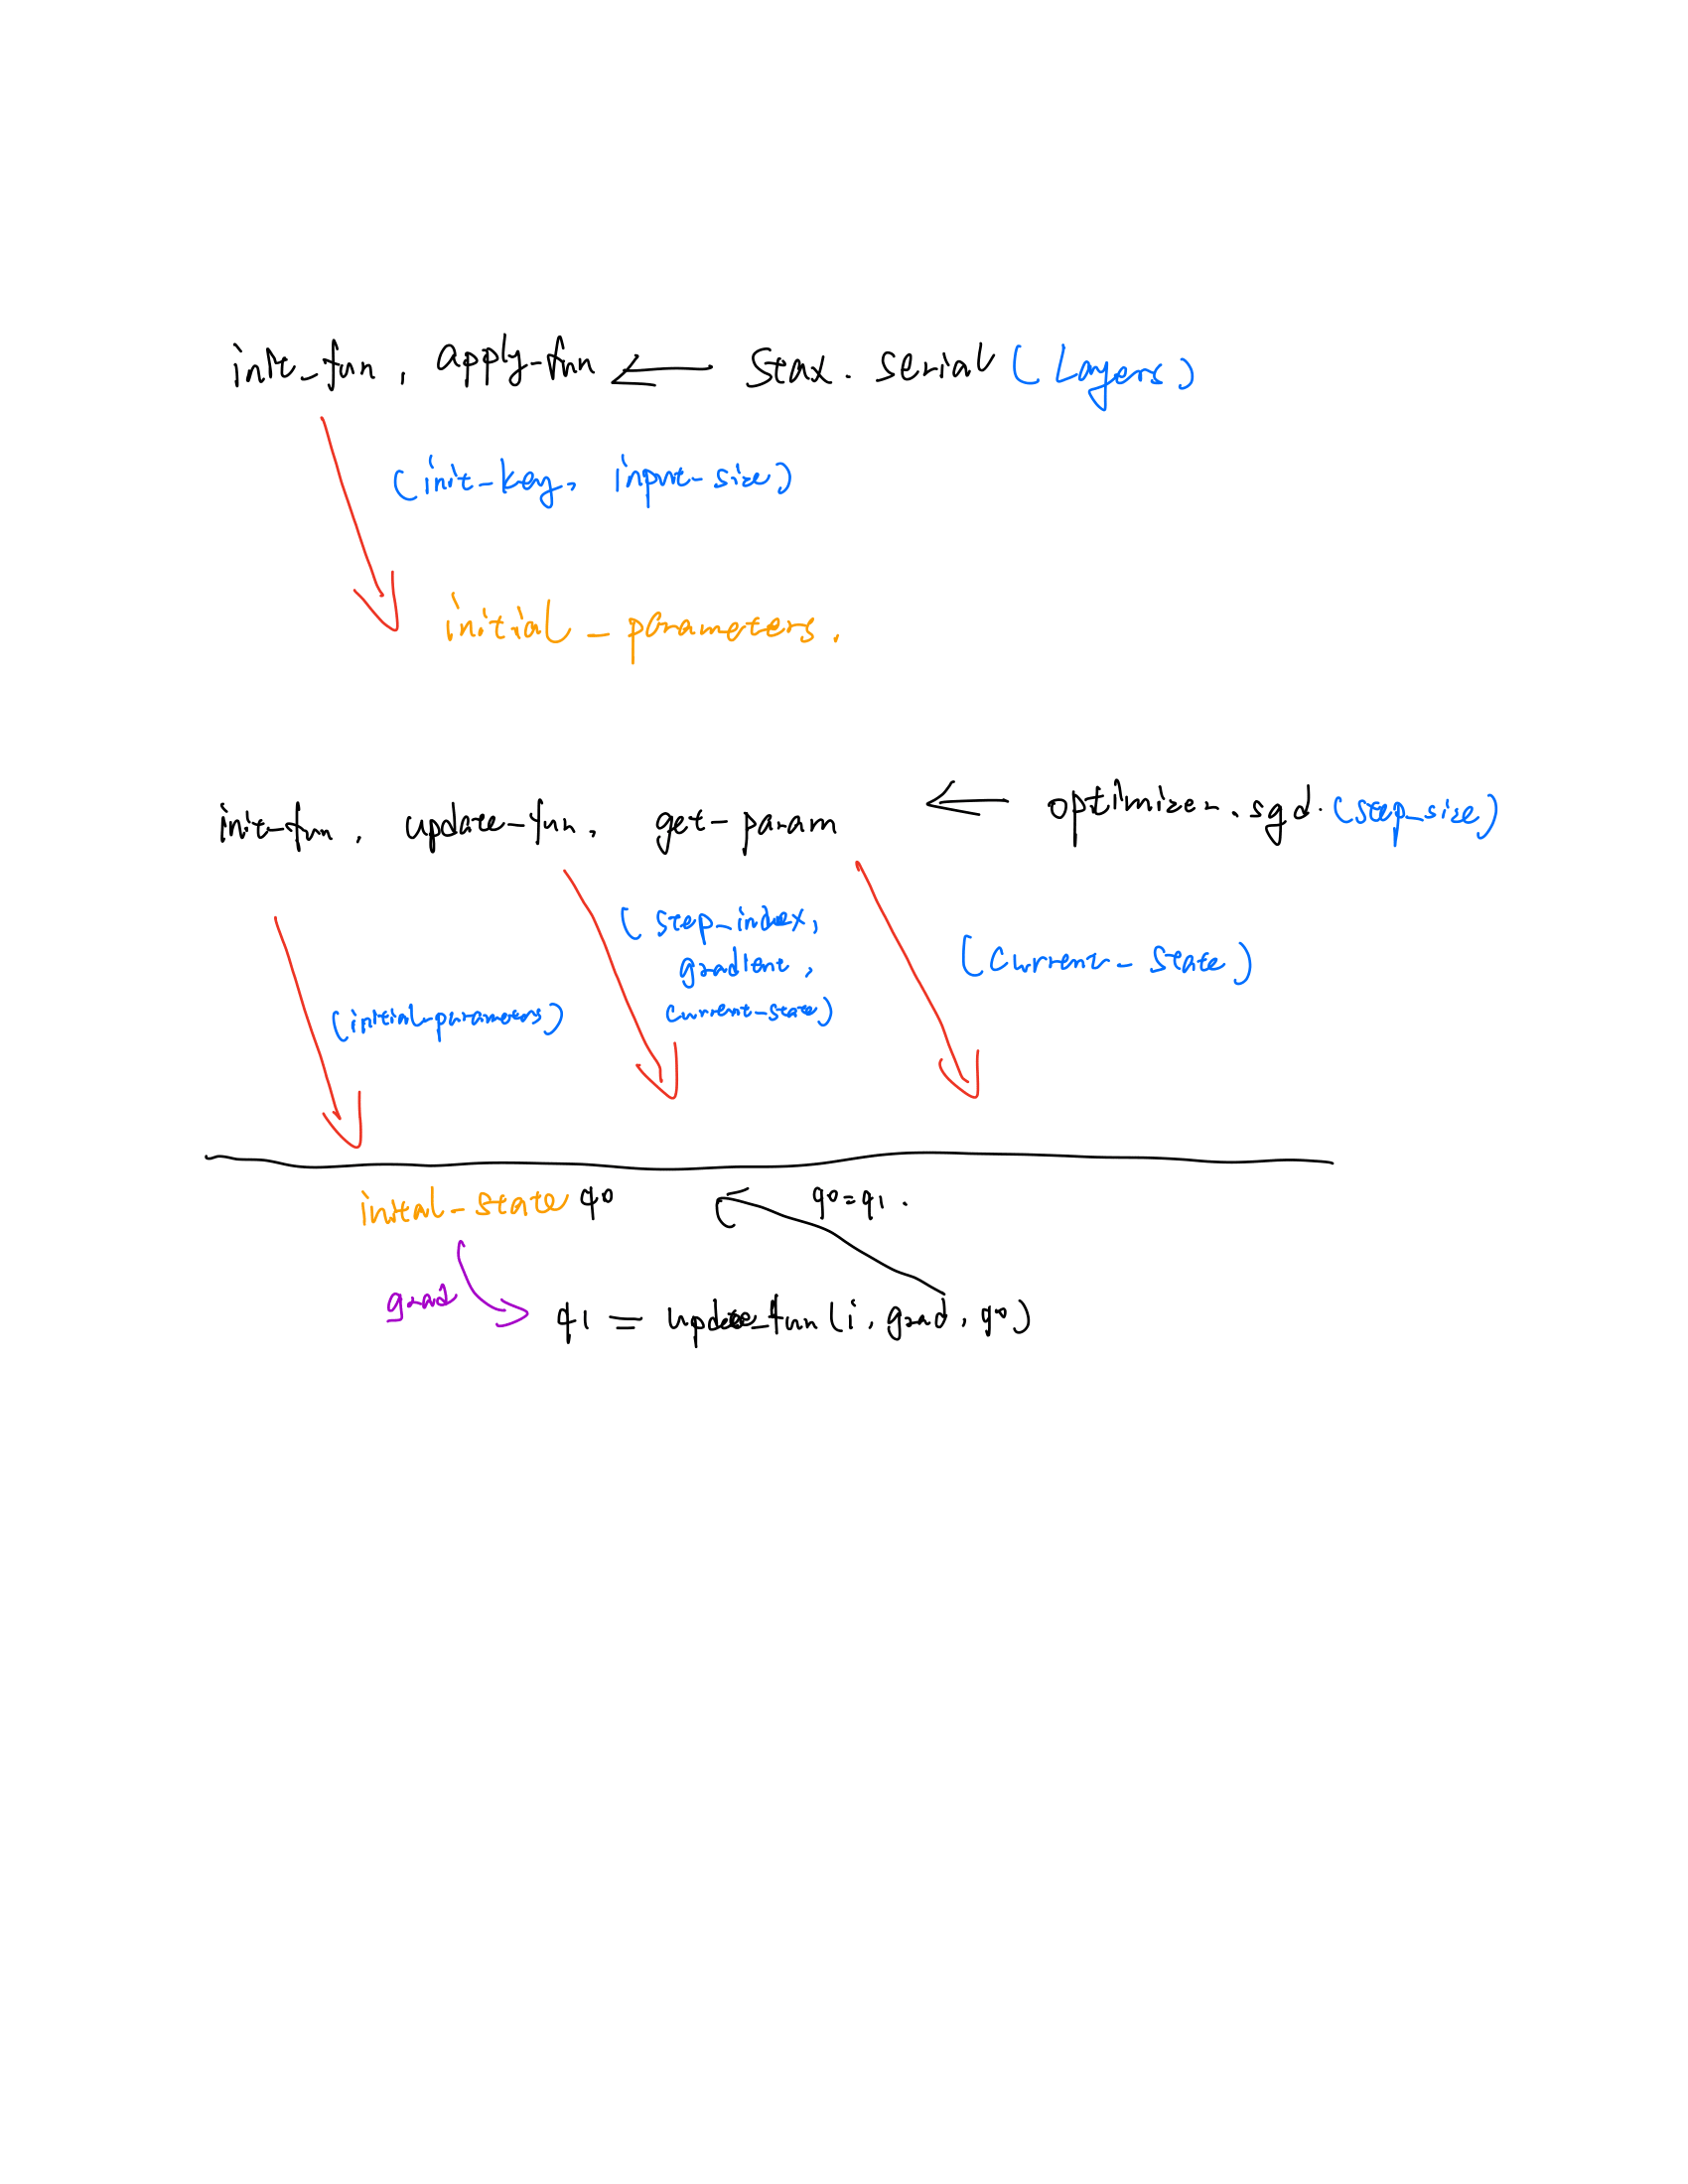